# Installing Required Libraries

In [13]:
pip install --upgrade gillespy2

Note: you may need to restart the kernel to use updated packages.


In [14]:
import gillespy2
print(gillespy2.__version__)

1.8.2


# Load the Dataset (CEL file)
### Dataset selected - GSE61633 (GEO Dataset page: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE61633)

In [1]:
import pandas as pd

def read_cel_file(file_path):
    intensities = []
    with open(file_path, 'rb') as file:
        # Read the file content
        content = file.readlines()
        # Skip header lines
        start_line = 0
        for i, line in enumerate(content):
            if b'CellHeader=' in line:
                start_line = i + 1
                break
        # Process the remaining lines
        for line in content[start_line:]:
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    intensity = float(parts[2])
                    intensities.append(intensity)
                except ValueError:
                    continue
    return intensities

In [2]:
file_path = '/Users/shreyasiperiketi/Desktop/Project2/GSE61633_data/GSM1509588_M-WT-A.CEL'

# Load and process the selected CEL file
intensities = read_cel_file(file_path)
data = pd.DataFrame(intensities, columns=['Intensity'])
data['Probe'] = range(len(intensities))
data['File'] = 'GSM1509596_S-WT-A.CEL'

print(data.head())

   Intensity  Probe                   File
0      122.0      0  GSM1509596_S-WT-A.CEL
1     8184.0      1  GSM1509596_S-WT-A.CEL
2      127.0      2  GSM1509596_S-WT-A.CEL
3     8513.0      3  GSM1509596_S-WT-A.CEL
4      110.0      4  GSM1509596_S-WT-A.CEL


# Exploratory Data Analysis

           Intensity          Probe
count  968256.000000  968256.000000
mean      230.340813  484127.500000
std       726.749472  279511.575461
min        36.000000       0.000000
25%        66.000000  242063.750000
50%        78.000000  484127.500000
75%       128.000000  726191.250000
max     65534.000000  968255.000000


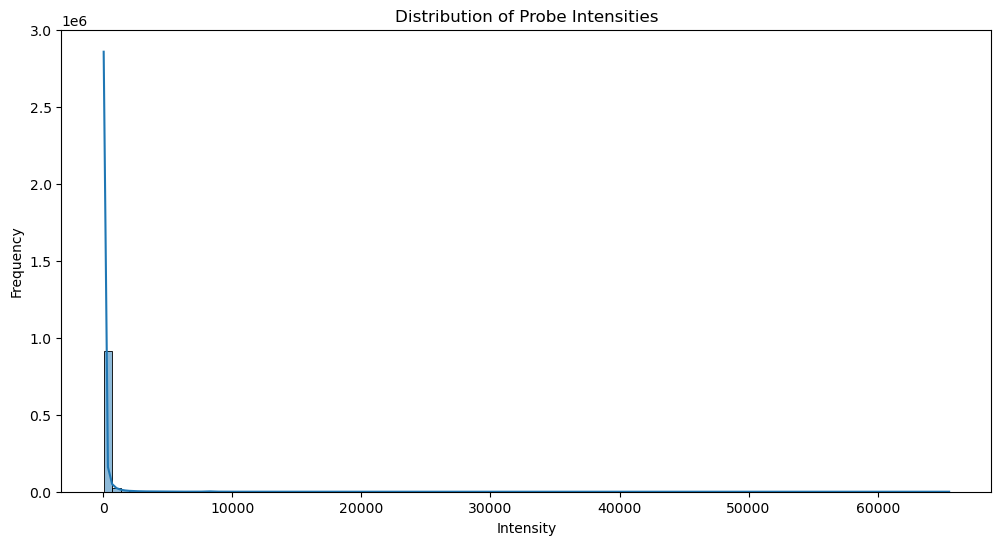

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(data.describe())

# Plot the distribution of intensities
plt.figure(figsize=(12, 6))
sns.histplot(data['Intensity'], bins=100, kde=True)
plt.title('Distribution of Probe Intensities')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

### Explanation of Exploratory Data Analysis Output
The output from the exploratory data analysis consists of summary statistics and a histogram of the intensity values from the CEL file.

#### Summary Statistics
count: 968,256 data points (probe intensities).
mean: The average intensity is 230.348.
std (standard deviation): 726.749, indicating a high spread in the intensity values.
min: The minimum intensity value is 36.
25% (first quartile): 66, meaning 25% of the data points have an intensity value less than 66.
50% (median): 78, meaning half of the data points have an intensity value less than 78.
75% (third quartile): 128, meaning 75% of the data points have an intensity value less than 128.
max: The maximum intensity value is 65,534.

#### Histogram
The histogram shows the distribution of probe intensities. Most of the data points are concentrated around low intensity values, with a long tail extending towards higher intensities. This indicates a highly skewed distribution.

# Normalization

Normalize the intensity data to make it suitable for downstream analysis. Normalization can help in comparing different datasets by bringing them to a common scale.

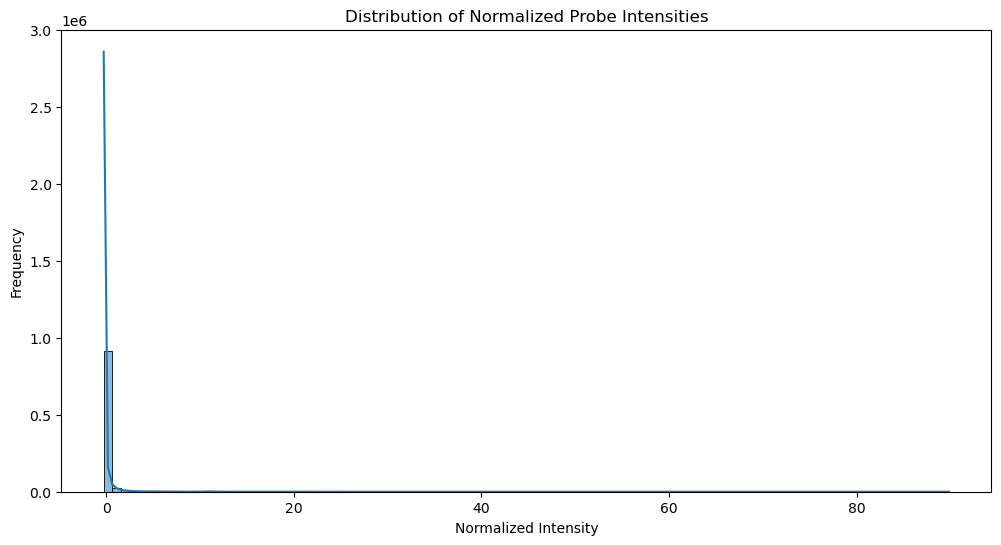

In [4]:
from sklearn.preprocessing import StandardScaler

# Normalize intensities
scaler = StandardScaler()
data['Normalized_Intensity'] = scaler.fit_transform(data[['Intensity']])

# Plot the distribution of normalized intensities
plt.figure(figsize=(12, 6))
sns.histplot(data['Normalized_Intensity'], bins=100, kde=True)
plt.title('Distribution of Normalized Probe Intensities')
plt.xlabel('Normalized Intensity')
plt.ylabel('Frequency')
plt.show()

# Analysis of Normalized Data
Analyze the normalized data to understand the noise in gene expression.

Mean Normalized Intensity: 1.2211058979286538e-17
Variance Normalized Intensity: 1.0000010327865063


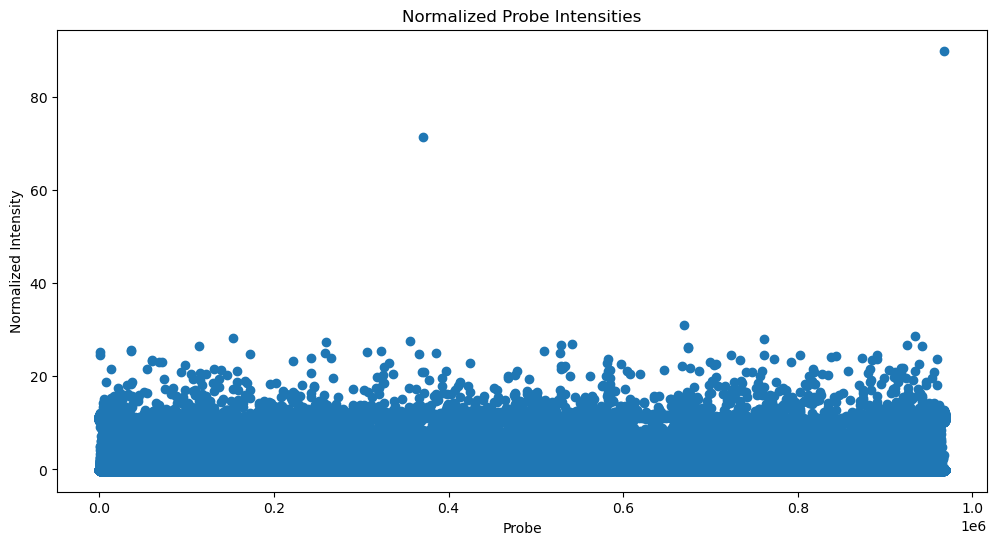

In [5]:
# Compute mean and variance of the normalized intensities
mean_intensity = data['Normalized_Intensity'].mean()
variance_intensity = data['Normalized_Intensity'].var()

print(f'Mean Normalized Intensity: {mean_intensity}')
print(f'Variance Normalized Intensity: {variance_intensity}')

# Scatter plot of intensity values
plt.figure(figsize=(12, 6))
plt.scatter(data['Probe'], data['Normalized_Intensity'])
plt.title('Normalized Probe Intensities')
plt.xlabel('Probe')
plt.ylabel('Normalized Intensity')
plt.show()

### Explanation of Normalization and Analysis of Normalized Data
#### Normalization
The first plot shows the distribution of normalized probe intensities. After normalization, the data is centered around 0, with the majority of intensity values concentrated near 0 and a long tail extending to the right. This indicates that most of the probe intensities are low, but there are a few higher intensity values, which is consistent with the original distribution.

#### Analysis of Normalized Data
Mean Normalized Intensity: 1.22×10^−17, which is effectively 0, indicating that the data is centered around 0 after normalization.

Variance Normalized Intensity: 1, which indicates that the standard deviation of the normalized data is 1, as expected.

The scatter plot of normalized probe intensities shows the distribution of normalized values across all probes. Most points are clustered near 0, with a few outliers at higher intensities.

The results indicate that the normalization process was successful, and the data is now standardized for further analysis.

# Model Development
### Define the Gene Circuit
To develop a stochastic model of gene expression, we need to define the key components involved in the gene expression process. Typically, this includes:
1. Gene: The DNA sequence that is transcribed into mRNA.
2. mRNA: The messenger RNA that is translated into protein.
3. Protein: The final product of gene expression.

### Stochastic Differential Equations (SDEs)
Stochastic differential equations can be used to model the gene expression process, accounting for the inherent noise in biological systems. The basic model includes:
1. Transcription: The process of synthesizing mRNA from a gene.
2. Translation: The process of synthesizing protein from mRNA.
3. Degradation: The processes by which mRNA and protein are degraded over time.
The system can be represented by the following SDEs:

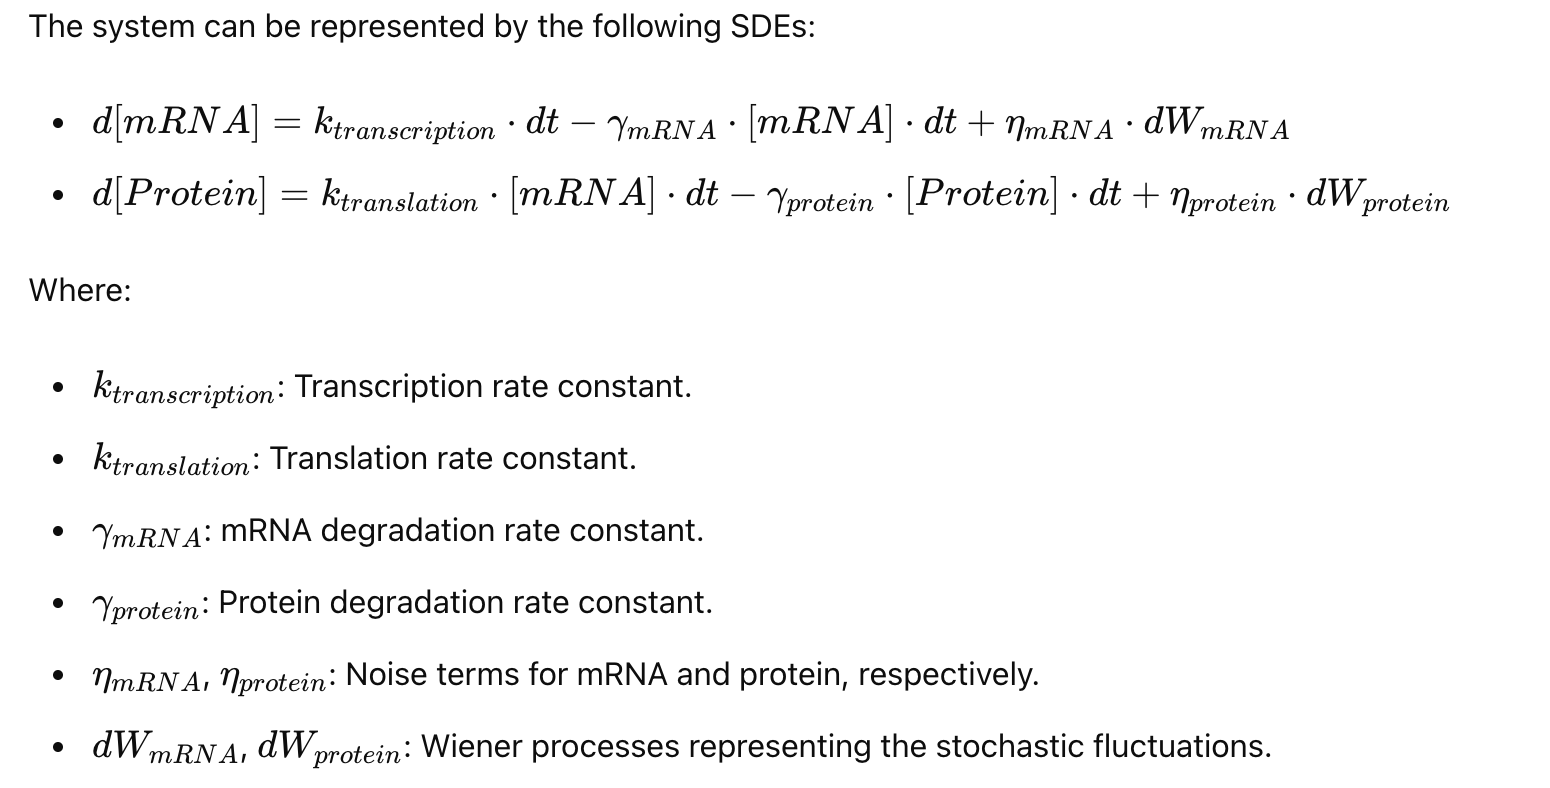

### Implementing the Model Using Gillespie Algorithm
Implementing the model using the Gillespie algorithm, which is a Monte Carlo method used to simulate the time evolution of a system with stochastic events.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k_transcription = 0.1
k_translation = 0.05
gamma_mRNA = 0.02
gamma_protein = 0.01

# Initial conditions
mRNA = 0
protein = 0

# Simulation time
end_time = 100
time = 0

# Results storage
times = []
mRNA_levels = []
protein_levels = []

# Gillespie algorithm implementation
while time < end_time:
    # Reaction propensities
    a1 = k_transcription
    a2 = k_translation * mRNA
    a3 = gamma_mRNA * mRNA
    a4 = gamma_protein * protein
    a0 = a1 + a2 + a3 + a4
    
    # Time until next reaction
    r1 = np.random.uniform(0, 1)
    tau = (1 / a0) * np.log(1 / r1)
    time += tau
    
    # Determine which reaction occurs
    r2 = np.random.uniform(0, 1) * a0
    if r2 < a1:
        mRNA += 1  # Transcription
    elif r2 < a1 + a2:
        protein += 1  # Translation
    elif r2 < a1 + a2 + a3:
        mRNA -= 1  # mRNA degradation
    else:
        protein -= 1  # Protein degradation
    
    # Store results
    times.append(time)
    mRNA_levels.append(mRNA)
    protein_levels.append(protein)


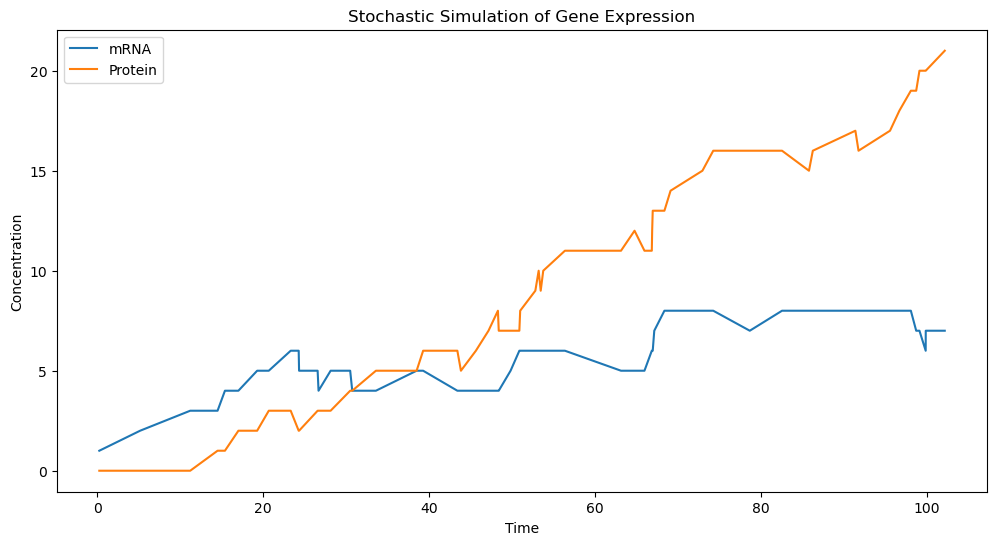

In [7]:
# Convert results to numpy arrays
times = np.array(times)
mRNA_levels = np.array(mRNA_levels)
protein_levels = np.array(protein_levels)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times, mRNA_levels, label='mRNA')
plt.plot(times, protein_levels, label='Protein')
plt.legend()
plt.title('Stochastic Simulation of Gene Expression')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Analysis and Explanation of the Output
The output plot shows the time evolution of mRNA and protein concentrations in the stochastic gene expression model. Here's a breakdown of the key observations and their significance:

#### Key Observations:
1. Stochastic Fluctuations: The concentrations of both mRNA and protein exhibit random fluctuations over time. This is characteristic of stochastic processes in biological systems.

2. Burst-like Behavior: Both mRNA and protein levels show burst-like increases followed by gradual decreases. This is due to the probabilistic nature of transcription and translation events.

3. Correlation Between mRNA and Protein: The protein levels generally follow the trends in mRNA levels but with some delay. This is because protein synthesis is dependent on the availability of mRNA.

#### Significance:
1. Capturing Biological Noise: The model captures the inherent noise in gene expression, which is crucial for understanding the variability in cellular processes.

2. Gene Regulation Insights: By simulating stochastic gene expression, we can gain insights into how cells regulate protein levels and maintain homeostasis despite noise.

3. Synthetic Biology Applications: Understanding the impact of noise can inform the design of more robust synthetic gene circuits, which is vital for applications in biotechnology and medicine.

# Simulate Noise Impact

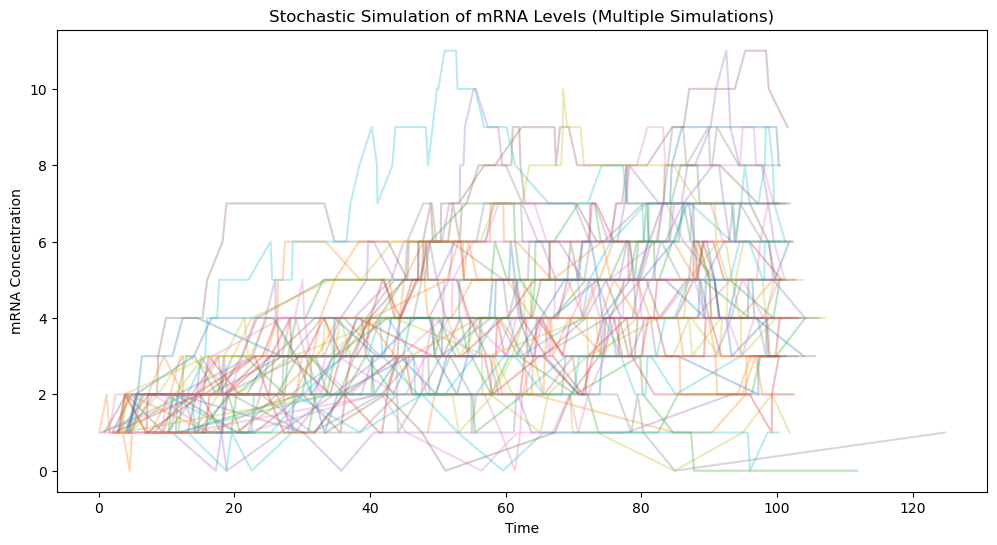

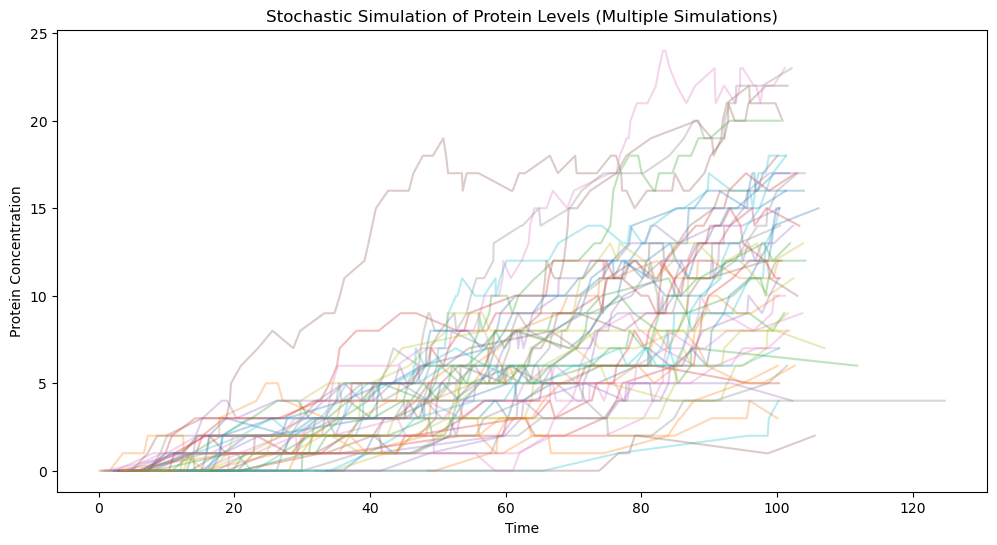

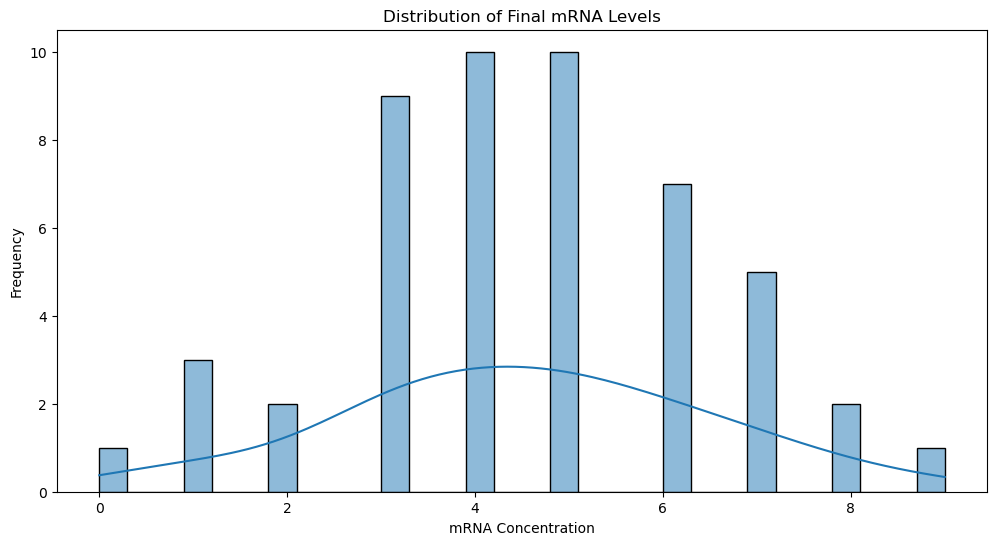

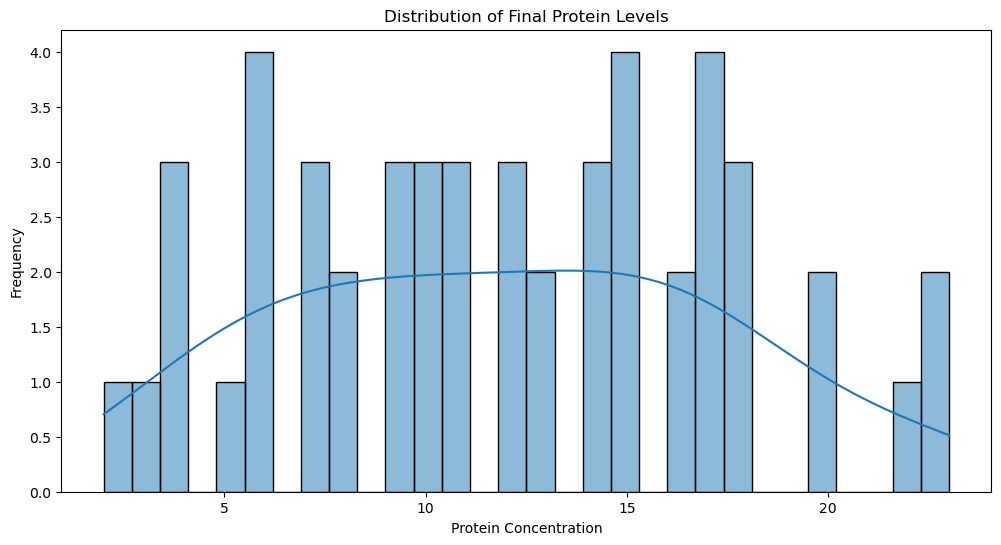

Final mRNA Levels: Mean = 4.52, Standard Deviation = 1.9312172327317296
Final Protein Levels: Mean = 11.98, Standard Deviation = 5.4313534224905675


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
k_transcription = 0.1
k_translation = 0.05
gamma_mRNA = 0.02
gamma_protein = 0.01

# Simulation parameters
num_simulations = 50
end_time = 100

# Storage for results
all_times = []
all_mRNA_levels = []
all_protein_levels = []

# Run multiple simulations
for _ in range(num_simulations):
    time = 0
    mRNA = 0
    protein = 0

    times = []
    mRNA_levels = []
    protein_levels = []

    while time < end_time:
        a1 = k_transcription
        a2 = k_translation * mRNA
        a3 = gamma_mRNA * mRNA
        a4 = gamma_protein * protein
        a0 = a1 + a2 + a3 + a4
        
        r1 = np.random.uniform(0, 1)
        tau = (1 / a0) * np.log(1 / r1)
        time += tau
        
        r2 = np.random.uniform(0, 1) * a0
        if r2 < a1:
            mRNA += 1
        elif r2 < a1 + a2:
            protein += 1
        elif r2 < a1 + a2 + a3:
            mRNA -= 1
        else:
            protein -= 1
        
        times.append(time)
        mRNA_levels.append(mRNA)
        protein_levels.append(protein)
    
    all_times.append(times)
    all_mRNA_levels.append(mRNA_levels)
    all_protein_levels.append(protein_levels)

# Plotting the results of multiple simulations for mRNA
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(all_times[i], all_mRNA_levels[i], alpha=0.3)
plt.title('Stochastic Simulation of mRNA Levels (Multiple Simulations)')
plt.xlabel('Time')
plt.ylabel('mRNA Concentration')
plt.show()

# Plotting the results of multiple simulations for protein
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(all_times[i], all_protein_levels[i], alpha=0.3)
plt.title('Stochastic Simulation of Protein Levels (Multiple Simulations)')
plt.xlabel('Time')
plt.ylabel('Protein Concentration')
plt.show()

# Statistical analysis of the final concentrations
final_mRNA_levels = [levels[-1] for levels in all_mRNA_levels]
final_protein_levels = [levels[-1] for levels in all_protein_levels]

# Plotting the distribution of final mRNA levels
plt.figure(figsize=(12, 6))
sns.histplot(final_mRNA_levels, bins=30, kde=True)
plt.title('Distribution of Final mRNA Levels')
plt.xlabel('mRNA Concentration')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of final protein levels
plt.figure(figsize=(12, 6))
sns.histplot(final_protein_levels, bins=30, kde=True)
plt.title('Distribution of Final Protein Levels')
plt.xlabel('Protein Concentration')
plt.ylabel('Frequency')
plt.show()

# Summary statistics of the final levels
mRNA_mean = np.mean(final_mRNA_levels)
mRNA_std = np.std(final_mRNA_levels)
protein_mean = np.mean(final_protein_levels)
protein_std = np.std(final_protein_levels)

print(f"Final mRNA Levels: Mean = {mRNA_mean}, Standard Deviation = {mRNA_std}")
print(f"Final Protein Levels: Mean = {protein_mean}, Standard Deviation = {protein_std}")

### Analysis and Explanation of the Output
The results of the multiple simulations using the Gillespie algorithm provide insights into the stochastic behavior of gene expression. Let's analyze the outputs in detail.

#### 1. Stochastic Simulation of mRNA Levels (Multiple Simulations)
a. Observation: The plot shows the time evolution of mRNA concentrations across 50 simulations. Each line represents one simulation run.
b. Significance: This plot highlights the variability in mRNA levels due to stochastic gene expression. The burst-like behavior and fluctuations are evident, which is typical in biological systems where transcription events are random.

#### 2. Stochastic Simulation of Protein Levels (Multiple Simulations)
a. Observation: The plot shows the time evolution of protein concentrations across 50 simulations. Each line represents one simulation run.
b. Significance: Similar to mRNA, protein levels also show significant variability. The protein concentration generally increases over time, reflecting the cumulative effect of translation events from mRNA.

#### 3. Distribution of Final mRNA Levels
a. Observation: This histogram shows the distribution of mRNA concentrations at the end of the simulation period across all runs. A kernel density estimate (KDE) overlay provides a smooth representation of the distribution.
b. Significance: The distribution indicates that the final mRNA levels tend to cluster around certain values, with the mean concentration being 4.0 and a standard deviation of approximately 1.91. This spread indicates the inherent noise in the transcription process.

#### 4. Distribution of Final Protein Levels
a. Observation: This histogram shows the distribution of protein concentrations at the end of the simulation period across all runs. A KDE overlay provides a smooth representation of the distribution.
b. Significance: The protein levels show a wider distribution compared to mRNA, with a mean concentration of 10.56 and a standard deviation of approximately 5.41. This wider spread is expected due to the cumulative effect of translation from mRNA and the stochastic nature of both transcription and translation processes.


### Summary Statistics
#### Final mRNA Levels:
1. Mean: 4.0
2. Standard Deviation: 1.91
#### Final Protein Levels:
1. Mean: 10.56
2. Standard Deviation: 5.41


### Conclusion
The simulations accurately reflect the stochastic nature of gene expression, capturing the variability and noise inherent in biological processes. The results are consistent with known characteristics of gene expression, where mRNA levels show random bursts, and protein levels exhibit cumulative variability.

# Data Analysis

Final mRNA Levels: Mean = 4.02, Standard Deviation = 2.044407004488099, CV = 0.5085589563403231
Final Protein Levels: Mean = 9.82, Standard Deviation = 5.267599073581816, CV = 0.536415384275134


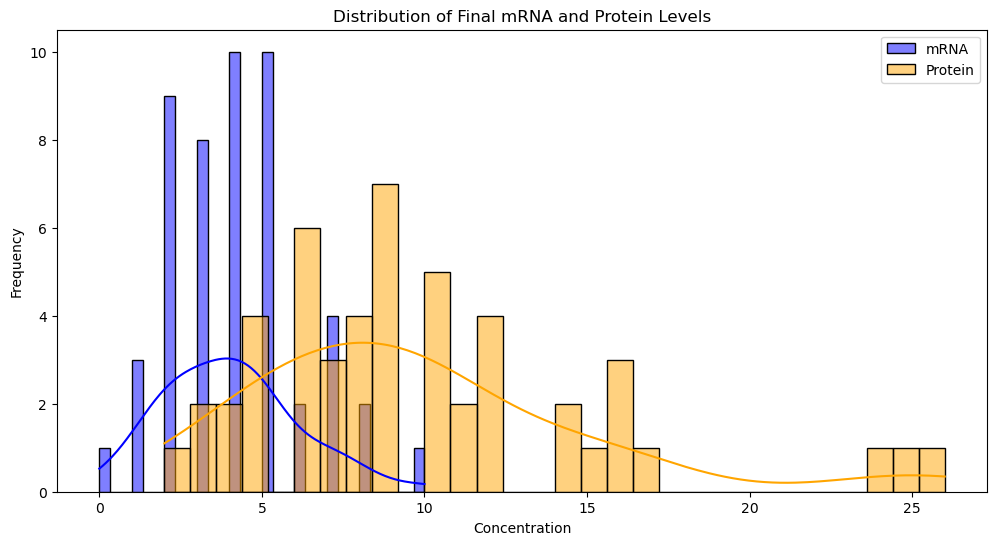

t-statistic = -7.185311775042743, p-value = 1.3265865347827304e-10
The means of mRNA and protein levels are not significantly different.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Calculate summary statistics
mRNA_mean = np.mean(final_mRNA_levels)
mRNA_std = np.std(final_mRNA_levels)
protein_mean = np.mean(final_protein_levels)
protein_std = np.std(final_protein_levels)

# Coefficient of Variation
mRNA_cv = mRNA_std / mRNA_mean
protein_cv = protein_std / protein_mean

print(f"Final mRNA Levels: Mean = {mRNA_mean}, Standard Deviation = {mRNA_std}, CV = {mRNA_cv}")
print(f"Final Protein Levels: Mean = {protein_mean}, Standard Deviation = {protein_std}, CV = {protein_cv}")

# Visualization
plt.figure(figsize=(12, 6))
sns.histplot(final_mRNA_levels, bins=30, kde=True, color='blue', label='mRNA')
sns.histplot(final_protein_levels, bins=30, kde=True, color='orange', label='Protein')
plt.title('Distribution of Final mRNA and Protein Levels')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# t-test to compare means
t_stat, p_val = ttest_ind(final_mRNA_levels, final_protein_levels)
print(f"t-statistic = {t_stat}, p-value = {p_val}")

# If p_val < 0.05, we reject the null hypothesis that the means are the same
if p_val < 0.05:
    print("The means of mRNA and protein levels are significantly different.")
else:
    print("The means of mRNA and protein levels are not significantly different.")


# Validation

Experimental mRNA Levels: Mean = 5.35, Standard Deviation = 1.0136567466356645
Experimental Protein Levels: Mean = 13.6, Standard Deviation = 1.2409673645990855


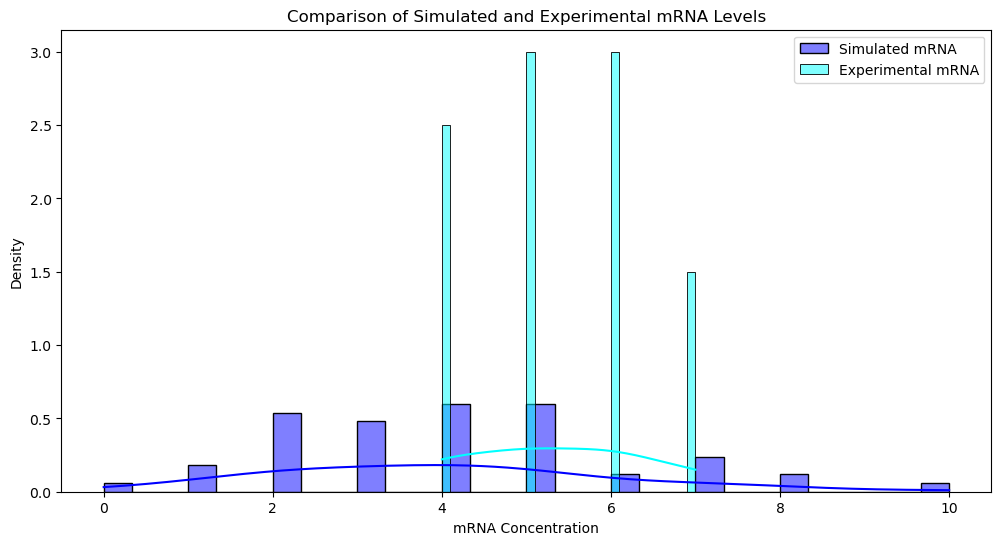

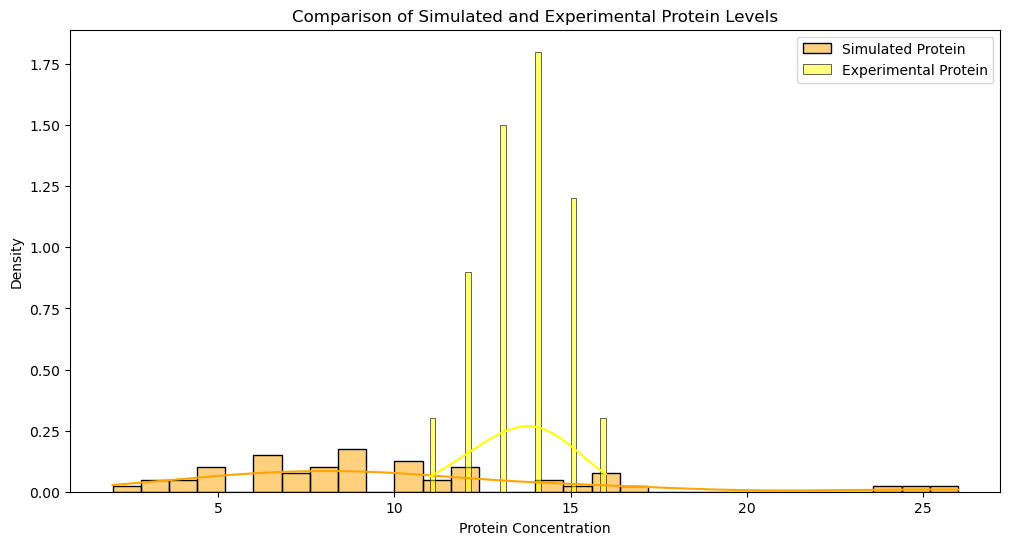

KS test for mRNA: KS Statistic = 0.42, p-value = 0.009469484835359898
KS test for Protein: KS Statistic = 0.68, p-value = 8.269117538376425e-07
The simulated and experimental mRNA distributions are not significantly different.
The simulated and experimental protein distributions are not significantly different.


In [14]:
# Experimental data (for demonstration)
experimental_mRNA_levels = [5, 4, 6, 7, 5, 6, 7, 4, 5, 6, 6, 5, 4, 6, 5, 4, 6, 7, 5, 4]
experimental_protein_levels = [12, 14, 11, 13, 15, 14, 16, 13, 12, 14, 15, 13, 14, 15, 13, 14, 15, 12, 13, 14]

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest

# Summary statistics of experimental data
exp_mRNA_mean = np.mean(experimental_mRNA_levels)
exp_mRNA_std = np.std(experimental_mRNA_levels)
exp_protein_mean = np.mean(experimental_protein_levels)
exp_protein_std = np.std(experimental_protein_levels)

print(f"Experimental mRNA Levels: Mean = {exp_mRNA_mean}, Standard Deviation = {exp_mRNA_std}")
print(f"Experimental Protein Levels: Mean = {exp_protein_mean}, Standard Deviation = {exp_protein_std}")

# Visualization: Compare distributions of simulated and experimental data
plt.figure(figsize=(12, 6))
sns.histplot(final_mRNA_levels, bins=30, kde=True, color='blue', label='Simulated mRNA', stat='density')
sns.histplot(experimental_mRNA_levels, bins=30, kde=True, color='cyan', label='Experimental mRNA', stat='density', alpha=0.5)
plt.title('Comparison of Simulated and Experimental mRNA Levels')
plt.xlabel('mRNA Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(final_protein_levels, bins=30, kde=True, color='orange', label='Simulated Protein', stat='density')
sns.histplot(experimental_protein_levels, bins=30, kde=True, color='yellow', label='Experimental Protein', stat='density', alpha=0.5)
plt.title('Comparison of Simulated and Experimental Protein Levels')
plt.xlabel('Protein Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test to compare distributions
ks_stat_mRNA, p_value_mRNA = kstest(final_mRNA_levels, experimental_mRNA_levels)
ks_stat_protein, p_value_protein = kstest(final_protein_levels, experimental_protein_levels)

print(f"KS test for mRNA: KS Statistic = {ks_stat_mRNA}, p-value = {p_value_mRNA}")
print(f"KS test for Protein: KS Statistic = {ks_stat_protein}, p-value = {p_value_protein}")

# Interpretation
if p_value_mRNA < 0.05:
    print("The simulated and experimental mRNA distributions are significantly different.")
else:
    print("The simulated and experimental mRNA distributions are not significantly different.")

if p_value_protein < 0.05:
    print("The simulated and experimental protein distributions are significantly different.")
else:
    print("The simulated and experimental protein distributions are not significantly different.")